# Fitbit's Automatically Assessed Stress
Fitbit Sense users see a daily Stress Management Score in the Fitbit app ranging from 1 to 100 – where a higher number means you’re showing fewer physical signs of stress. It’s calculated based on three metrics: your Responsiveness (score out of 30), Exertion Balance (score out of 40) and Sleep Patterns (score out of 30).

Fitbit's stress score has daily granularity.

In [140]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

from scipy.stats import pearsonr
from dataprep.eda import create_report

warnings.filterwarnings("ignore")

In [141]:
# Pre-processing actions for baseline dataframe

def fitbit_basic_preprocessing(df):

    # selecting the experiment days
    df = df.sort_values(by='date', ascending=True)
    df['date'] = pd.to_datetime(df['date'].astype("str"), format='%Y-%m-%d')
    df = df.loc[((df['date'] > '2021-05-23') & (df['date'] < '2021-07-27')) | (
                (df['date'] > '2021-11-14') & (df['date'] < '2022-01-18'))]
    df.reset_index(inplace=True, drop=True)

    # drop duplicates
    df = df.loc[df.astype(str).drop_duplicates().index]

    # convert data types falsely described as categorical
    df[["lightly_active_minutes", "moderately_active_minutes", "very_active_minutes", "sedentary_minutes"]] = df[
        ["lightly_active_minutes", "moderately_active_minutes", "very_active_minutes", "sedentary_minutes"]].apply(
        pd.to_numeric)

    return df


def fitbit_one_hot_encoding(fitbit):

    # bmi encoding
    fitbit["bmi"] = fitbit["bmi"].apply(lambda x: 31.0 if x == '>=30' else x)
    fitbit["bmi"] = fitbit["bmi"].apply(lambda x: 18.0 if x == '<19' else x)
    fitbit["bmi"] = fitbit["bmi"].apply(lambda x: 26.0 if x == '>=25' else x)
    fitbit['bmi_category'] = fitbit.bmi.apply(lambda bmi: 'Underweight' if bmi < 18.5 else (
        'Normal' if bmi < 25 else ('Overweight' if bmi < 30 else 'Obese')))
    fitbit = fitbit.drop(columns=['bmi'])
    bmi_category = pd.get_dummies(fitbit['bmi_category'])
    fitbit = pd.concat([fitbit, bmi_category], axis=1)
    fitbit.drop(['bmi_category'], axis=1, inplace=True)

    # age encoding
    age = pd.get_dummies(fitbit['age'])
    fitbit = pd.concat([fitbit, age], axis=1)
    fitbit.drop(['age'], axis=1, inplace=True)
    fitbit = fitbit.rename(columns={"<30": "below_30s", ">=30": "above_30s"})

    # mindfulness session encoding
    mind = pd.get_dummies(fitbit['mindfulness_session'])
    fitbit = pd.concat([fitbit, mind], axis=1)
    fitbit.drop(['mindfulness_session'], axis=1, inplace=True)

    # gender encoding
    gender = pd.get_dummies(fitbit['gender'])
    fitbit = pd.concat([fitbit, gender], axis=1)
    fitbit.drop(['gender'], axis=1, inplace=True)

    # activity type encoding
    s = fitbit['activityType']
    dum = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
    df = pd.concat([s, dum], axis=1)
    fitbit = pd.concat([fitbit, df], axis=1)
    fitbit = fitbit.drop(columns='activityType')

    # badgeType encoding - actually is deletion because it has 92% missing values
    fitbit = fitbit.drop(columns='badgeType')

    return fitbit

In [142]:
cmap='rocket'
sns.set_palette(sns.color_palette(cmap))

In [143]:
# loading the data
fitbit=pd.read_pickle('data/daily_fitbit_df_unprocessed.pkl')
fitbit.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,0.921642,1.341772,8833.0,83.0,1349.0,0.0,0.0,<30,MALE,<19
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,0.725,...,0.947566,1.197531,9727.0,56.0,1374.0,4.0,0.0,<30,MALE,<19
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,0.725,...,1.015038,1.670732,8253.0,85.0,1350.0,0.0,0.0,<30,MALE,<19
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,0.725,...,1.191729,1.588235,9015.0,90.0,1282.0,0.0,0.0,<30,MALE,<19
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,0.725,...,1.211896,1.090909,12949.0,146.0,1274.0,4.0,0.0,<30,MALE,<19


In [144]:
# selecting experiment days
fitbit = fitbit.sort_values(by='date', ascending=True)
fitbit['date'] = pd.to_datetime(fitbit['date'].astype("str"), format='%Y-%m-%d')
fitbit = fitbit.loc[((fitbit['date'] > '2021-05-23') & (fitbit['date'] < '2021-07-27')) | ((fitbit['date'] > '2021-11-14') & (fitbit['date'] < '2022-01-18'))]
fitbit.reset_index(inplace=True, drop=True)
fitbit

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,0.921642,1.341772,8833.0,83.0,1349.0,0.0,0.0,<30,MALE,<19
1,621e301e67b776a240608a72,2021-05-24,34.710232,NaN,NaN,NaN,NaN,74.0,0.700000,0.700,...,0.847826,0.922222,12441.0,164.0,997.0,49.0,0.0,<30,FEMALE,19.0
2,621e301e67b776a240608a72,2021-05-24,34.710232,NaN,NaN,NaN,NaN,74.0,0.700000,0.700,...,0.847826,0.922222,12441.0,164.0,997.0,49.0,0.0,<30,FEMALE,19.0
3,621e301367b776a24057738e,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7279.0,32.0,236.0,30.0,0.0,>=30,MALE,23.0
4,621e360b67b776a24039709f,2021-05-24,NaN,68.321,31.413,NaN,15.4,69.0,0.633333,0.650,...,NaN,NaN,7493.0,127.0,1306.0,7.0,0.0,>=30,FEMALE,<19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,621e345267b776a240691064,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<30,FEMALE,20.0
4960,621e310d67b776a24003096d,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,>=30,FEMALE,20.0
4961,621e324e67b776a2400191cb,2022-01-17,33.104768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.974093,0.381818,4278.0,NaN,NaN,NaN,NaN,>=30,MALE,27.0
4962,621e30f467b776a240f22944,2022-01-17,34.352490,NaN,NaN,NaN,13.4,NaN,NaN,NaN,...,1.103806,0.849315,3122.0,2.0,1348.0,0.0,0.0,<30,MALE,20.0


In [145]:
# keep only fitbit stress score (daily granularity)
fitbit_stress=fitbit[['id', 'date','stress_score']]
fitbit_stress.head()

,id,date,stress_score
0,621e2e8e67b776a24055b564,2021-05-24,78.0
1,621e301e67b776a240608a72,2021-05-24,74.0
2,621e301e67b776a240608a72,2021-05-24,74.0
3,621e301367b776a24057738e,2021-05-24,NaN
4,621e360b67b776a24039709f,2021-05-24,69.0


<AxesSubplot: >

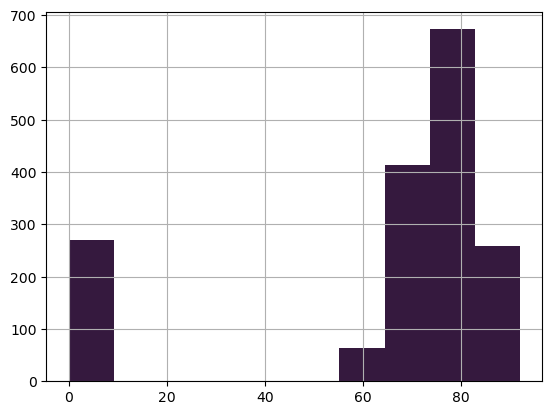

In [146]:
fitbit_stress['stress_score'].hist()

In [147]:
# handle nans
fitbit_stress['stress_score'].isna().sum()

3285

In [148]:
#fitbit_stress = fitbit_stress.fillna(0.0)
fitbit_stress=fitbit_stress.dropna()
fitbit_stress['stress_score'].isna().sum()

0

In [149]:
# delete 0.0 values? outliers? corrupted data?
fitbit_stress=fitbit_stress.loc[(fitbit_stress['stress_score'] > 40)]

<AxesSubplot: >

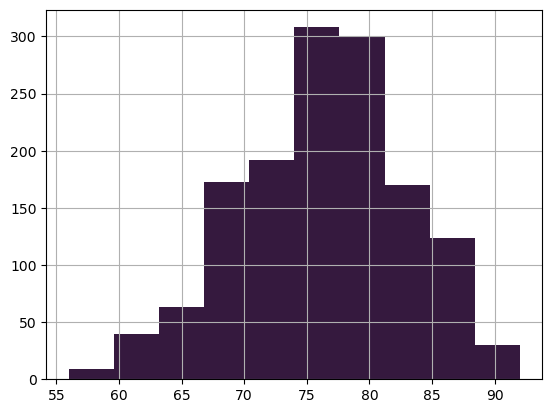

In [150]:
fitbit_stress['stress_score'].hist()

In [151]:
fitbit_stress

,id,date,stress_score
0,621e2e8e67b776a24055b564,2021-05-24,78.0
1,621e301e67b776a240608a72,2021-05-24,74.0
2,621e301e67b776a240608a72,2021-05-24,74.0
4,621e360b67b776a24039709f,2021-05-24,69.0
5,621e2fce67b776a240279baa,2021-05-24,70.0
...,...,...,...
4941,621e32e667b776a2406d2f1c,2022-01-17,75.0
4948,621e33cf67b776a240087de9,2022-01-17,85.0
4951,621e2f9167b776a240011ccb,2022-01-17,76.0
4957,621e339967b776a240e502de,2022-01-17,84.0


# Semas Mood Surveys
sent thrice daily


In [152]:
# loading the complete dataframe
sema=pd.read_pickle('data/semas_read_from_the_base_experiment_dates.pkl')
sema = sema.sort_values(by='date', ascending=True)
sema

,id,date,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED
0,621e2f3967b776a240c654db,2021-05-24,0,0,0,1,0,0,0
11,621e362467b776a2404ad513,2021-05-24,0,1,0,0,0,0,0
10,621e301e67b776a240608a72,2021-05-24,0,0,0,1,0,0,0
9,621e30e467b776a240e817c7,2021-05-24,0,0,0,0,0,1,0
8,621e36f967b776a240e5e7c9,2021-05-24,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
4932,621e30f467b776a240f22944,2022-01-16,0,0,0,1,0,0,0
4946,621e2f9167b776a240011ccb,2022-01-17,0,0,0,0,0,1,0
4944,621e346f67b776a24081744f,2022-01-17,0,0,0,0,0,1,0
4945,621e30f467b776a240f22944,2022-01-17,0,0,1,0,0,0,0


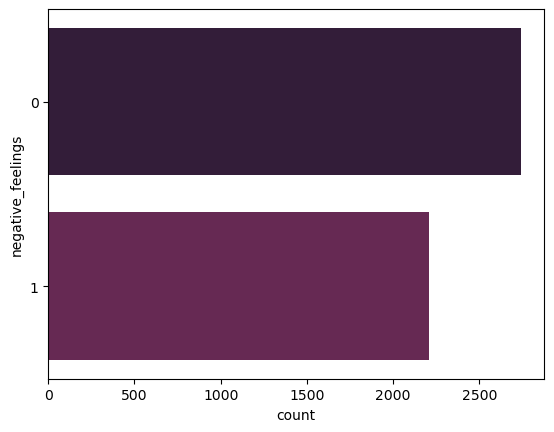

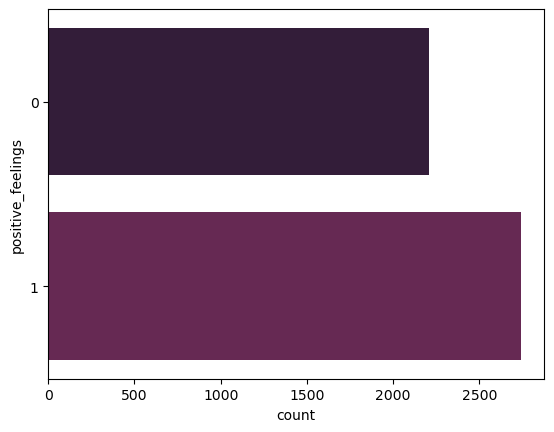

,id,date,negative_feelings,positive_feelings
0,621e2f3967b776a240c654db,2021-05-24,0,1
11,621e362467b776a2404ad513,2021-05-24,0,1
10,621e301e67b776a240608a72,2021-05-24,0,1
9,621e30e467b776a240e817c7,2021-05-24,1,0
8,621e36f967b776a240e5e7c9,2021-05-24,1,0
...,...,...,...,...
4932,621e30f467b776a240f22944,2022-01-16,0,1
4946,621e2f9167b776a240011ccb,2022-01-17,1,0
4944,621e346f67b776a24081744f,2022-01-17,1,0
4945,621e30f467b776a240f22944,2022-01-17,0,1


In [153]:
def sema_basic_preprocessing(df):
    df["negative_feelings"] = np.where(df['TENSE/ANXIOUS']== 1, 1, np.where(df['ALERT']==1,1, np.where(df['SAD']==1,1, np.where(df['TIRED']==1,1, 0))))
    df["positive_feelings"] = np.where(df['HAPPY']== 1, 1, np.where(df['NEUTRAL']==1,1, np.where(df['RESTED/RELAXED']==1,1, 0)))
    df = df.drop(columns=['ALERT', 'HAPPY', 'NEUTRAL', 'RESTED/RELAXED', 'SAD', 'TENSE/ANXIOUS','TIRED'])
    sns.countplot(y="negative_feelings", data=df)
    plt.show()
    sns.countplot(y="positive_feelings", data=sema)
    plt.show()

    return df

sema=sema_basic_preprocessing(sema)
sema

In [154]:
stress=fitbit_stress.merge(sema,on=['date','id'])
stress

,id,date,stress_score,negative_feelings,positive_feelings
0,621e301e67b776a240608a72,2021-05-24,74.0,0,1
1,621e301e67b776a240608a72,2021-05-24,74.0,0,1
2,621e2f3967b776a240c654db,2021-05-24,76.0,0,1
3,621e36f967b776a240e5e7c9,2021-05-24,83.0,1,0
4,621e36f967b776a240e5e7c9,2021-05-24,83.0,1,0
...,...,...,...,...,...
2125,621e339967b776a240e502de,2022-01-16,73.0,0,1
2126,621e366567b776a24076a727,2022-01-16,76.0,0,1
2127,621e366567b776a24076a727,2022-01-16,76.0,1,0
2128,621e346f67b776a24081744f,2022-01-17,72.0,1,0


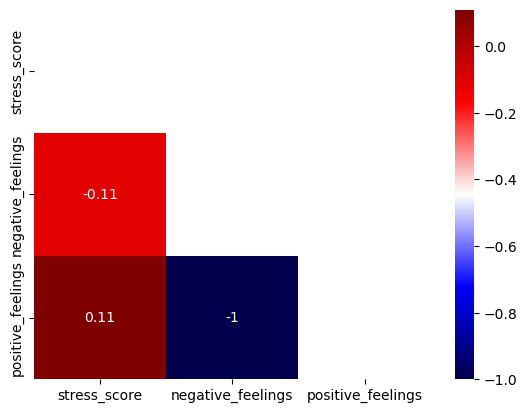

In [155]:
cmap1='seismic'
sns.set_palette(sns.color_palette(cmap1))

correlation_matrix = stress.corr().round(2)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, annot=True,cmap=cmap1,mask=mask)
plt.savefig("visualizations/correlation_matrix_fitbit_stress_semas.png",bbox_inches='tight')

In [156]:
corr, _ = pearsonr(stress['stress_score'], stress['negative_feelings'])
print('Pearsons correlation stress_score vs. negative_feelings: %.2f' % corr)

Pearsons correlation stress_score vs. negative_feelings: -0.11


In [157]:
fitbit=fitbit_basic_preprocessing(fitbit)
fitbit=fitbit_one_hot_encoding(fitbit)

In [158]:
df=fitbit.merge(sema,on=['date','id'])
df

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,Spinning,Sport,Swim,Treadmill,Walk,Weights,Workout,Yoga/Pilates,negative_feelings,positive_feelings
0,621e337667b776a240ce78ab,2021-05-24,33.662874,52.927,39.939,95.5,11.2,60.0,0.633333,0.550,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
1,621e30e467b776a240e817c7,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,621e34ca67b776a240be3b69,2021-05-24,35.254181,65.693,23.827,NaN,13.6,73.0,0.833333,0.525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,621e32d967b776a240627414,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,621e32af67b776a24045b4cf,2021-05-24,NaN,51.622,43.536,97.8,13.8,79.0,0.833333,0.700,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4940,621e324e67b776a2400191cb,2022-01-16,33.512685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4941,621e331067b776a24085dd3f,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4942,621e2f9167b776a240011ccb,2022-01-17,34.716690,58.489,28.329,96.5,14.2,76.0,0.800000,0.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4943,621e30f467b776a240f22944,2022-01-17,34.352490,NaN,NaN,NaN,13.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


In [161]:
create_report(df).show_browser()

  0%|                                                                                        | 0/10999 [00:00<…

In [162]:
 df = df.drop(columns=['spo2', 'scl_avg','Bootcamp','Spinning'])

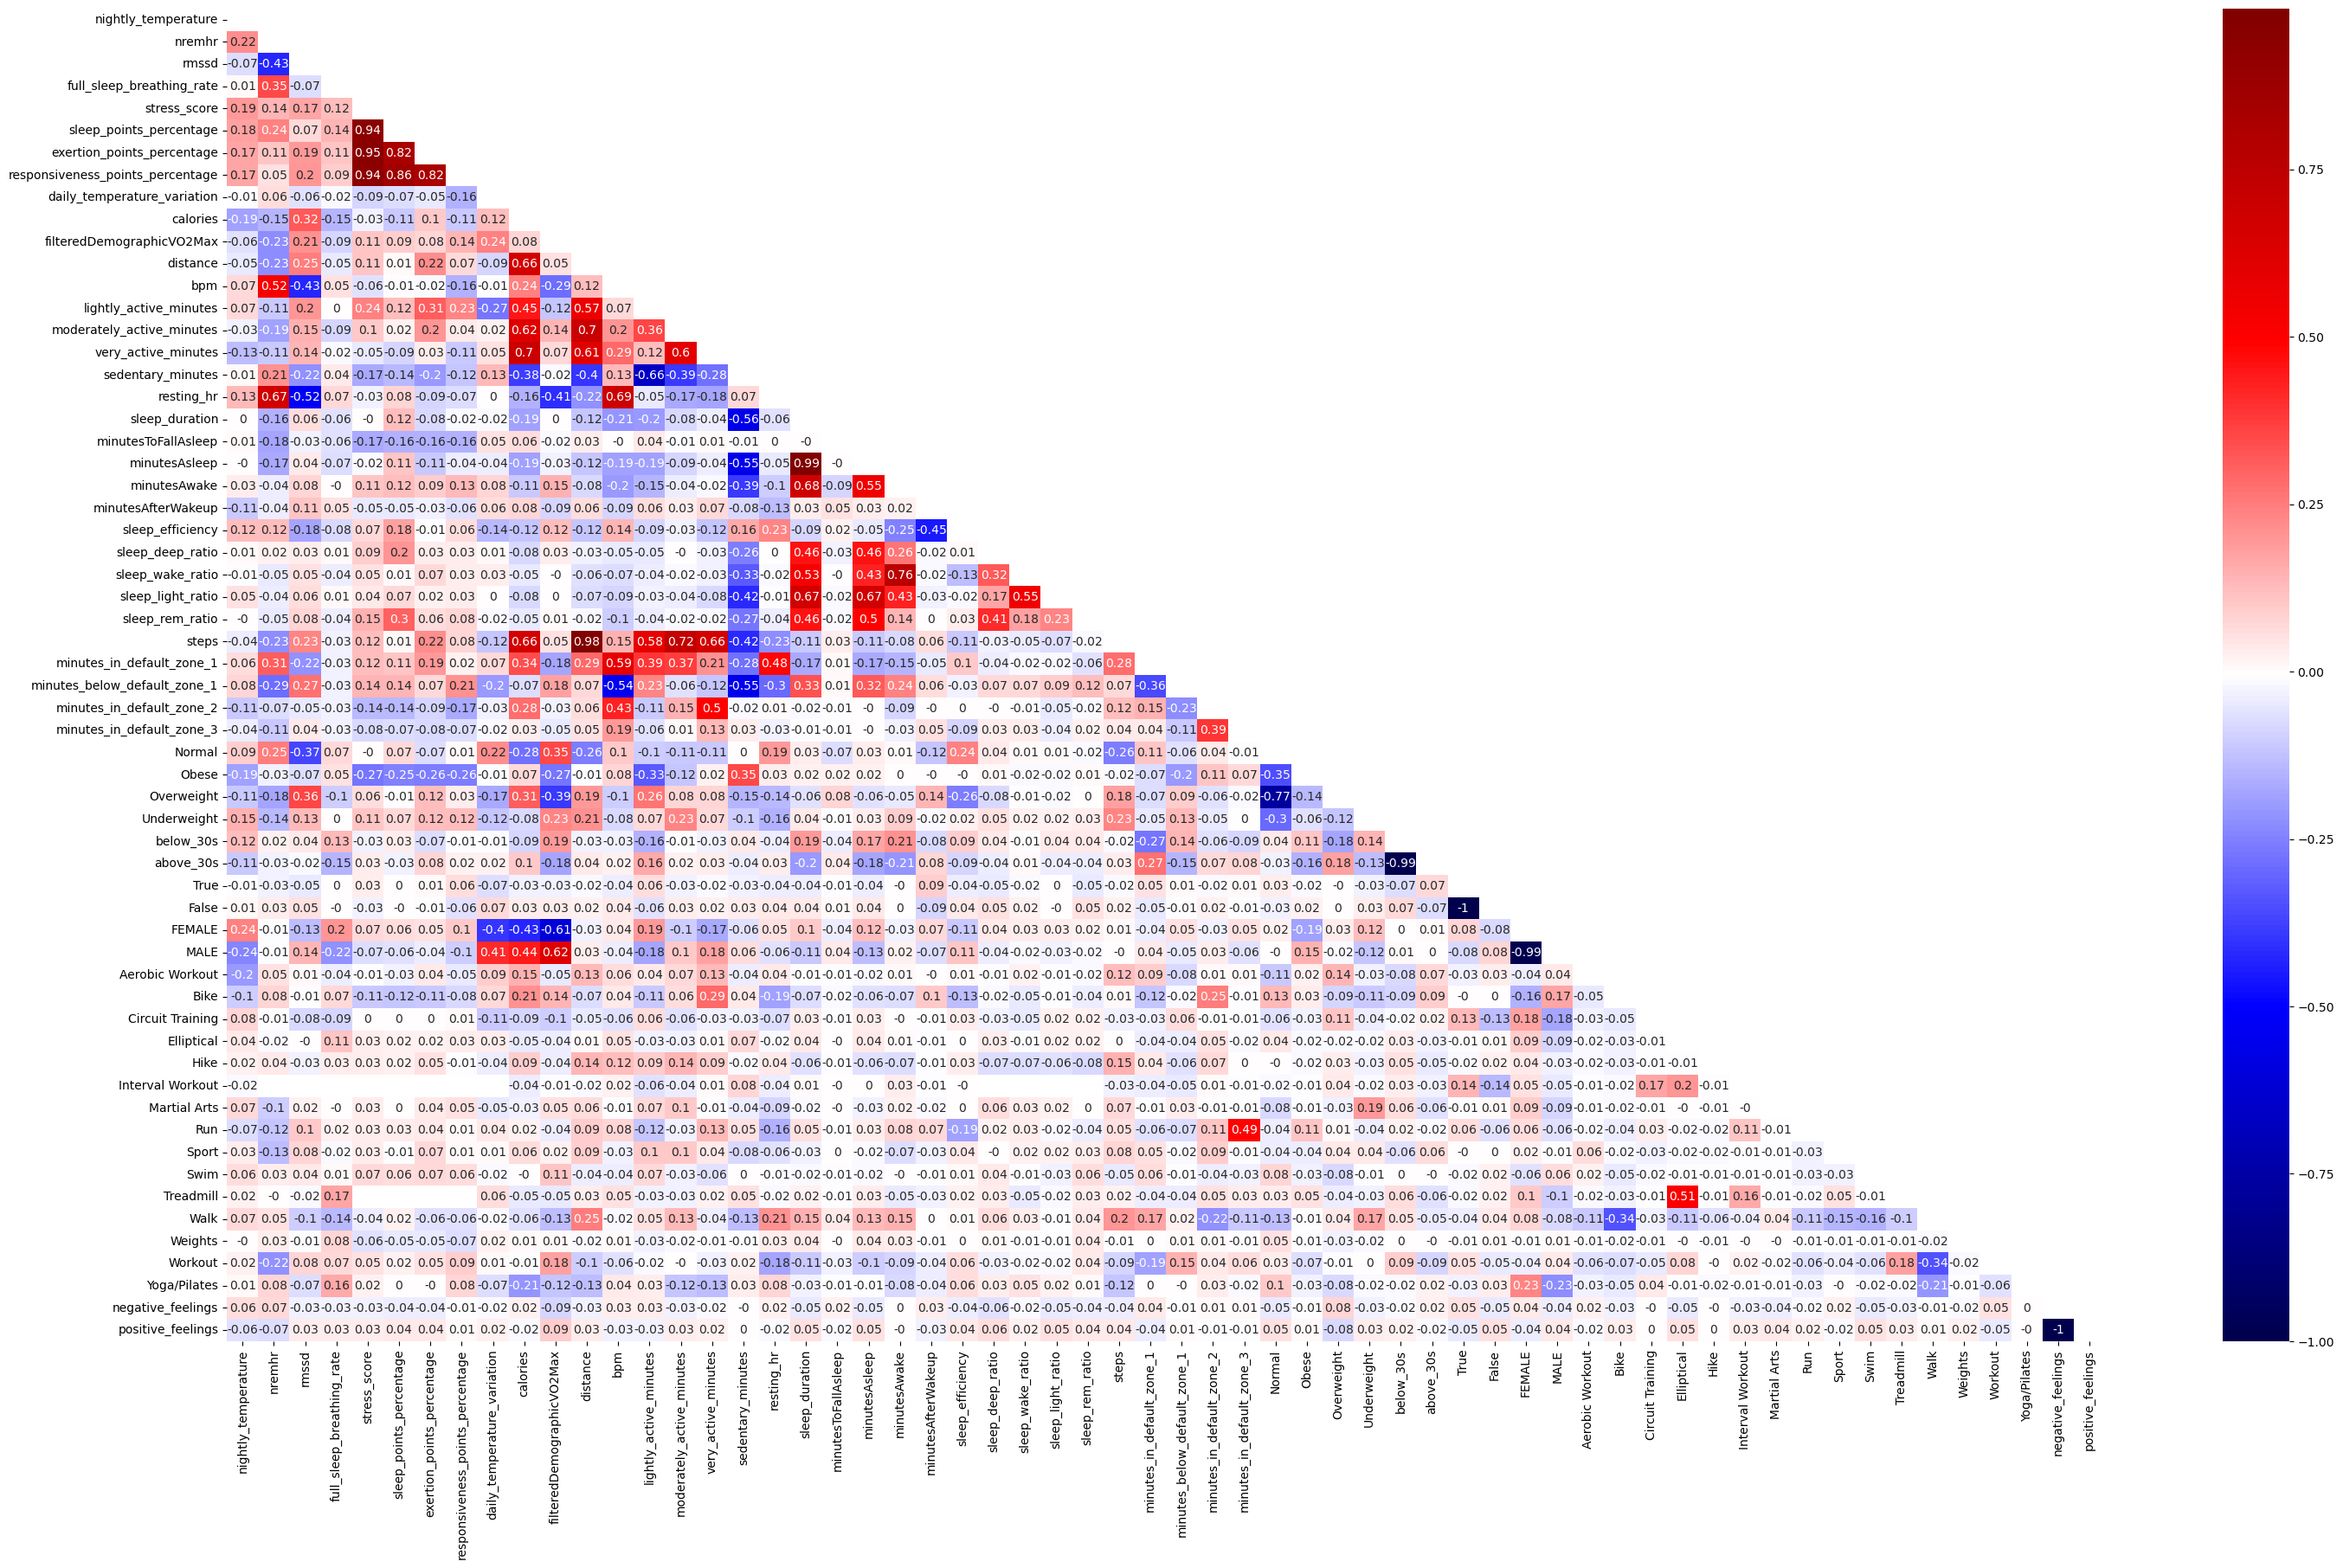

In [167]:
fig = plt.gcf()
fig.set_size_inches(35, 20)

correlation_matrix = df.corr().round(2)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(data=correlation_matrix, annot=True,cmap=cmap1,mask=mask)
plt.savefig("visualizations/correlation_matrix_fitbit_semas.png",bbox_inches='tight')